# Machine Learning

### Will a dog (already in the shelter) get adopted?
* Predict outcome of a dog

In [29]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score


import warnings
warnings.filterwarnings('ignore')

In [3]:
unique_df = pd.read_csv("../data/unique_austin_shelter.csv")
unique_df.set_index("animal_id", inplace=True)

In [21]:
features = ['is_mixed','intake_condition', 'intake_type', 'sex', 'fixed', 'time_in_shelter', 'age_in']
features1 = ['intake_condition', 'intake_type', 'sex', 'fixed', 'time_in_shelter', 'age_in']
features2 = ['is_mixed', 'sex', 'fixed', 'time_in_shelter', 'age_in']
features3 = ['intake_condition', 'sex', 'time_in_shelter', 'age_in']
features4 = ['is_mixed', 'intake_type', 'sex', 'fixed', 'age_in']
features5 = ['is_mixed', 'sex', 'fixed', 'age_in']

In [22]:
new_unique_df = unique_df[unique_df.in_shelter == "No"][['is_mixed', 'intake_condition', 'intake_type', 'sex', 'fixed', 'time_in_shelter', 'age_in','outcome_type']]

In [23]:
temp = new_unique_df.time_in_shelter.apply(pd.to_timedelta)
temp = temp.apply(lambda x:( x.days*24*60*60 + x.seconds)/60)
new_unique_df.time_in_shelter = temp
new_unique_df.time_in_shelter.dtype


dtype('float64')

In [24]:
new_unique_df.dropna(inplace=True)

**Hyperparameter Tuning**
1. Features
2. Scaling
3. K 

In [25]:
new_unique_df.head()

,is_mixed,intake_condition,intake_type,sex,fixed,time_in_shelter,age_in,outcome_type
animal_id,,,,,,,,
A786884,1,Normal,Stray,Male,Yes,7132.0,2.0,Transfer
A706918,0,Normal,Stray,Female,Yes,134.0,8.0,Return to Owner
A724273,1,Normal,Stray,Male,No,9994.0,1.0,Return to Owner
A778404,1,Normal,Owner Surrender,Male,No,4784.0,4.0,Adoption
A682524,1,Normal,Stray,Male,Yes,4538.0,4.0,Return to Owner


## Defining Training Data

In [26]:
x_train_dict = new_unique_df[features].to_dict(orient="records")
y_train = new_unique_df['outcome_type']

In [27]:
vec = DictVectorizer(sparse=False)
vec.fit(x_train_dict)
x_train = vec.transform(x_train_dict)

scaler = Normalizer()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)

## Model: KNeighborsClassifier 
### Feature Selection

In [28]:
model = KNeighborsClassifier(n_neighbors=30, n_jobs=-1)
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()

pipeline = Pipeline([
    ("vectorizer", vec), 
    ("scaler", scaler), 
    ("model", model)
])


for feat in [features, features1, features2, features3, features4, features5]:
    x_train_dict = new_unique_df[feat].to_dict(orient="records")
    y_train = new_unique_df['outcome_type']
    print(feat, cross_val_score(pipeline, x_train_dict, y_train, cv=5, scoring="accuracy").mean())

['is_mixed', 'intake_condition', 'intake_type', 'sex', 'fixed', 'time_in_shelter', 'age_in'] 0.6971530504115181
['intake_condition', 'intake_type', 'sex', 'fixed', 'time_in_shelter', 'age_in'] 0.70163558915865
['is_mixed', 'sex', 'fixed', 'time_in_shelter', 'age_in'] 0.6404590170368781
['intake_condition', 'sex', 'time_in_shelter', 'age_in'] 0.647650275690558
['is_mixed', 'intake_type', 'sex', 'fixed', 'age_in'] 0.5567718064738866
['is_mixed', 'sex', 'fixed', 'age_in'] 0.5119780145296502


features1 was the best

### Scaler testing

In [36]:
x_train_dict = new_unique_df[features1].to_dict(orient="records")
y_train = new_unique_df['outcome_type']

In [37]:
scalers = [StandardScaler(), Normalizer(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()]

In [38]:
grid = GridSearchCV(pipeline,param_grid=dict(scaler=scalers),cv=5, verbose=5, n_jobs=-1)
grid.fit(x_train_dict, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:  1.7min remaining:   58.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:  2.0min remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'scaler': [StandardScaler(copy=True, with_mean=True, with_std=True), Normalizer(copy=True, norm='l2'), MinMaxScaler(copy=True, feature_range=(0, 1)), MaxAbsScaler(copy=True), RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [39]:
print(grid.best_score_)
print(grid.best_estimator_.steps)

0.7065734832371113
[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('model', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
           weights='uniform'))]


In [40]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.052805,2.826535,7.965209,3.085577,"StandardScaler(copy=True, with_mean=True, with...","{'scaler': StandardScaler(copy=True, with_mean...",0.699190,0.706582,0.702925,0.702545,...,0.701636,0.003318,2,0.715290,0.713788,0.716094,0.715525,0.717116,0.715563,0.001088
1,2.966998,0.564824,5.674741,0.882539,"Normalizer(copy=True, norm='l2')","{'scaler': Normalizer(copy=True, norm='l2')}",0.698810,0.707215,0.699380,0.699253,...,0.700344,0.003535,3,0.713928,0.711731,0.715145,0.714480,0.716388,0.714334,0.001539
2,3.812916,1.190793,4.673145,1.449552,"MinMaxScaler(copy=True, feature_range=(0, 1))","{'scaler': MinMaxScaler(copy=True, feature_ran...",0.696786,0.699873,0.695327,0.698493,...,0.696647,0.002479,4,0.711301,0.709673,0.711568,0.711537,0.712654,0.711347,0.000959
3,5.145111,0.846617,7.430025,0.390906,MaxAbsScaler(copy=True),{'scaler': MaxAbsScaler(copy=True)},0.696786,0.699747,0.694821,0.698620,...,0.696495,0.002604,5,0.711206,0.709452,0.711505,0.711537,0.712590,0.711258,0.001018
4,2.040941,0.654370,3.469866,1.585345,"RobustScaler(copy=True, quantile_range=(25.0, ...","{'scaler': RobustScaler(copy=True, quantile_ra...",0.703493,0.711013,0.706597,0.706091,...,0.706573,0.002460,1,0.718740,0.717840,0.719639,0.721190,0.721389,0.719760,0.001374


Robust scaler is the best

### K value testing

In [43]:
x_train_dict = new_unique_df[features1].to_dict(orient="records")
y_train = new_unique_df['outcome_type']

vec = DictVectorizer(sparse=False)
vec.fit(x_train_dict)
x_train = vec.transform(x_train_dict)

scaler = RobustScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)

model = KNeighborsClassifier(n_jobs=-1)

In [44]:
n = [5,10,20,30,40,50]
ks = pd.Series()
ks.index = n
test_errs.ks.apply()

In [45]:
grid = GridSearchCV(model,param_grid=dict(n_neighbors=ks),cv=5)
grid.fit(x_train_sc, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [5, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)

0.7071558796718322
40


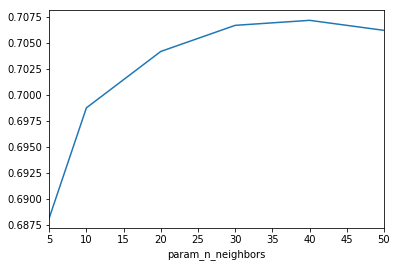

In [52]:
pd.DataFrame(grid.cv_results_).set_index("param_n_neighbors")['mean_test_score'].plot.line()

k=40

## Model: RandomForestClassifier

In [54]:
model = RandomForestClassifier(n_jobs=-1)
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()

pipeline = Pipeline([
    ("vectorizer", vec), 
    ("scaler", scaler), 
    ("model", model)
])


for feat in [features, features1, features2, features3, features4, features5]:
    x_train_dict = new_unique_df[feat].to_dict(orient="records")
    y_train = new_unique_df['outcome_type']
    print(feat, cross_val_score(pipeline, x_train_dict, y_train, cv=5, scoring="accuracy").mean())

['is_mixed', 'intake_condition', 'intake_type', 'sex', 'fixed', 'time_in_shelter', 'age_in'] 0.6530440308125804
['intake_condition', 'intake_type', 'sex', 'fixed', 'time_in_shelter', 'age_in'] 0.6509176501850181
['is_mixed', 'sex', 'fixed', 'time_in_shelter', 'age_in'] 0.5705971276166315
['intake_condition', 'sex', 'time_in_shelter', 'age_in'] 0.5759396983858641
['is_mixed', 'intake_type', 'sex', 'fixed', 'age_in'] 0.5650260612953572
['is_mixed', 'sex', 'fixed', 'age_in'] 0.5228661492148154


features

### Scaler Testing

In [55]:
x_train_dict = new_unique_df[features].to_dict(orient="records")
y_train = new_unique_df['outcome_type']

In [56]:
scalers = [StandardScaler(), Normalizer(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()]

In [57]:
grid = GridSearchCV(pipeline,param_grid=dict(scaler=scalers),cv=5, verbose=5, n_jobs=-1)
grid.fit(x_train_dict, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   16.6s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   22.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   25.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'scaler': [StandardScaler(copy=True, with_mean=True, with_std=True), Normalizer(copy=True, norm='l2'), MinMaxScaler(copy=True, feature_range=(0, 1)), MaxAbsScaler(copy=True), RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [58]:
print(grid.best_score_)
print(grid.best_estimator_.steps)

0.6844677403018333
[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('scaler', Normalizer(copy=True, norm='l2')), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]


In [59]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.463739,0.049157,0.153403,0.002868,"StandardScaler(copy=True, with_mean=True, with...","{'scaler': StandardScaler(copy=True, with_mean...",0.644394,0.658228,0.659111,0.648854,...,0.652664,0.005576,4,0.952137,0.952994,0.952018,0.950055,0.951766,0.951794,0.000963
1,0.461668,0.017738,0.153075,0.003597,"Normalizer(copy=True, norm='l2')","{'scaler': Normalizer(copy=True, norm='l2')}",0.678562,0.690380,0.686590,0.683804,...,0.684468,0.003923,1,0.907249,0.906274,0.907169,0.904763,0.906254,0.906342,0.000896
2,0.444430,0.044151,0.157617,0.008575,"MinMaxScaler(copy=True, feature_range=(0, 1))","{'scaler': MinMaxScaler(copy=True, feature_ran...",0.646925,0.659873,0.659238,0.651387,...,0.653474,0.005174,3,0.952168,0.950842,0.952366,0.950404,0.951450,0.951446,0.000751
3,0.438518,0.040227,0.150395,0.002422,MaxAbsScaler(copy=True),{'scaler': MaxAbsScaler(copy=True)},0.643888,0.660253,0.659491,0.649994,...,0.653575,0.006112,2,0.953973,0.951602,0.953315,0.951828,0.951734,0.952490,0.000967
4,0.391922,0.052007,0.153726,0.004880,"RobustScaler(copy=True, quantile_range=(25.0, ...","{'scaler': RobustScaler(copy=True, quantile_ra...",0.639205,0.659241,0.653413,0.650627,...,0.651296,0.006658,5,0.952422,0.950082,0.952113,0.952682,0.950817,0.951623,0.001002


### Parameter tuning

In [62]:
x_train_dict = new_unique_df[features].to_dict(orient="records")
y_train = new_unique_df['outcome_type']

vec = DictVectorizer(sparse=False)
vec.fit(x_train_dict)
x_train = vec.transform(x_train_dict)

scaler = Normalizer()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)

model = RandomForestClassifier(n_jobs=-1)

In [68]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 50, 90, 100],
    'max_features': [2, 3],
    'random_state': [10],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [10, 12, 15],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
grid = GridSearchCV(model,param_grid=param_grid,cv=5, n_jobs=-1, verbose=2)
grid.fit(x_train_sc, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   54.9s


In [ ]:
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)

In [ ]:
y_train_pred = model.predict(x_train_sc)

**TRAINING**

In [ ]:
print("Training Accuracy")
print(accuracy_score(y_train, y_train_pred))

In [ ]:
print("Training Precision")
print(precision_score(y_train, y_train_pred,pos_label="Adoption", average=None).mean())

In [ ]:
print("Training Recall")
print(recall_score(y_train, y_train_pred,pos_label="Adoption", average=None).mean())

In [ ]:
true_positives = ((y_train_pred == "Transfer") & (y_train == "Transfer")).sum()

precision = true_positives / (y_train_pred == "Transfer").sum()
recall = true_positives / (y_train == "Transfer").sum()
    
precision, recall

In [ ]:
pipeline = Pipeline([
    ("vectorizer", vec), 
    ("scaler", scaler), 
    ("model", model)
])

print(cross_val_score(pipeline, x_train_dict, y_train, cv=10, scoring="accuracy").mean())

In [26]:
x_train_dict = new_unique_df[features1].to_dict(orient="records")
y_train = new_unique_df['outcome_type']

vec = DictVectorizer(sparse=False)
vec.fit(x_train_dict)
x_train = vec.transform(x_train_dict)

scaler = Normalizer()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)

model = KNeighborsClassifier(n_neighbors=30)
model.fit(x_train_sc, y_train)

new_dog = pd.DataFrame()
new_dog['sex'] = ['Male']
new_dog['fixed'] = ['No']
new_dog['time_in_shelter'] = [5000.0]
new_dog['age_in'] = [4.0]

In [27]:
new_dog = new_dog.to_dict(orient="records")
new_dog = vec.transform(new_dog)
new_dog_sc = scaler.transform(new_dog)

preds = model.predict(new_dog_sc)


In [28]:
preds

array(['Adoption'], dtype=object)

In [ ]:
new_unique_df[:10]